── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

diabetes_binary,mean_bmi,sd_bmi
<fct>,<dbl>,<dbl>
Case,20.816,7.185918
Control,16.936,6.598711


Warning message:
“Removed 2 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_bar()`).”


diabetes_binary,mean_gen_hlth,mean_ment_hlth,sd_gen_hlth,sd_ment_hlth
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Case,3.322,5.786,0.9921112,9.442591
Control,2.404,4.316,1.0013938,7.193026


diabetes_binary,age,n
<fct>,<fct>,<int>
Case,"[18,24]",1
Case,"[30,34]",6
Case,"[35,39]",8
Case,"[40,44]",17
Case,"[45,49]",25
Case,"[50,54]",37
Case,"[55,59]",68
Case,"[60,64]",79
Case,"[65,69]",99


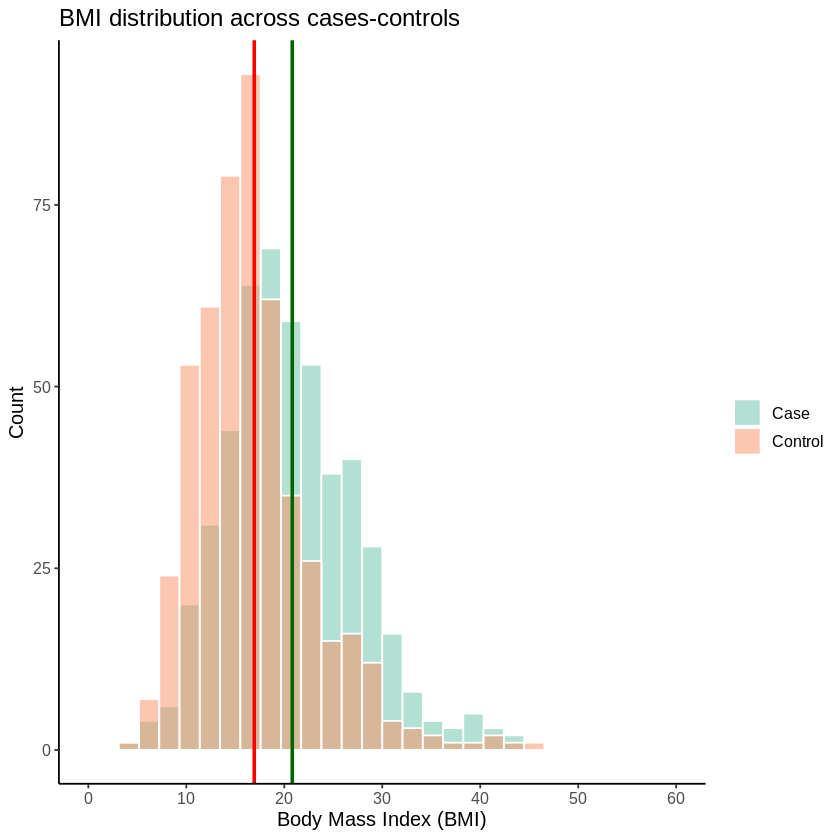

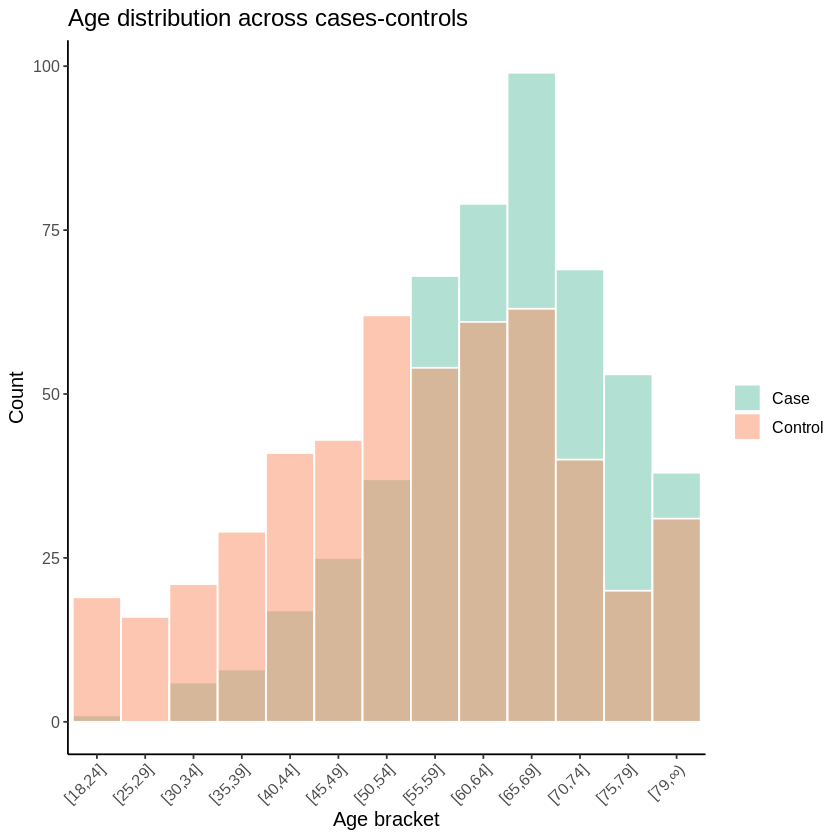

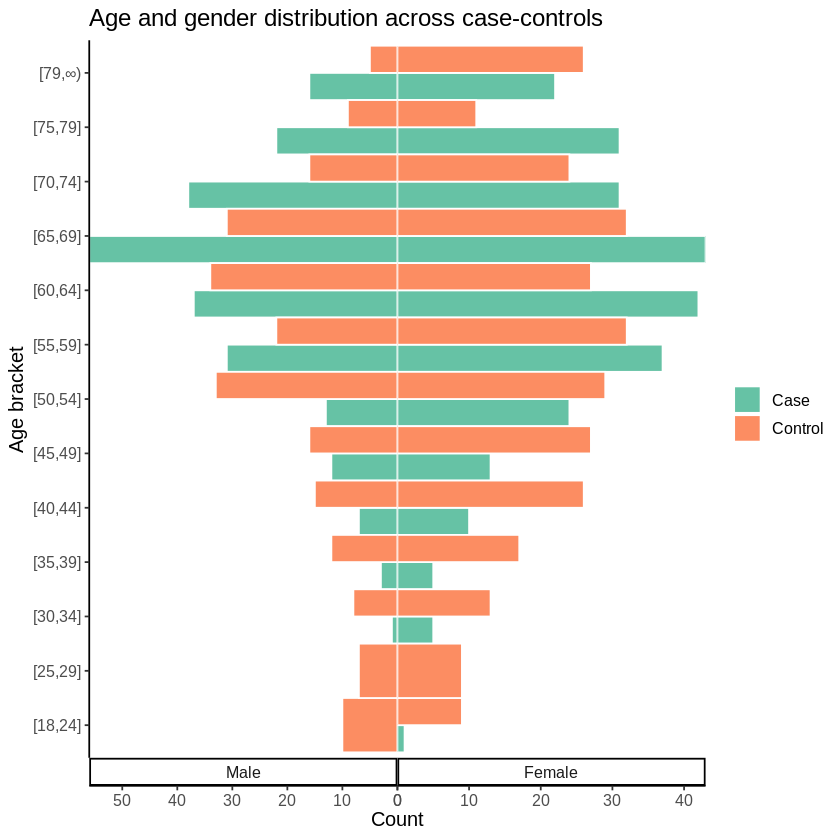

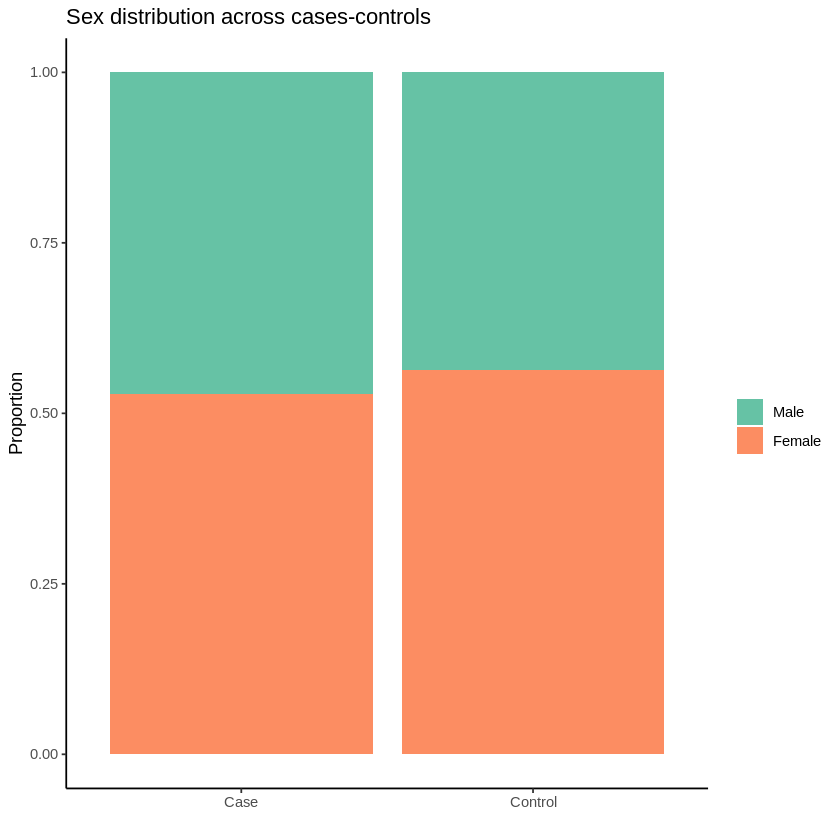

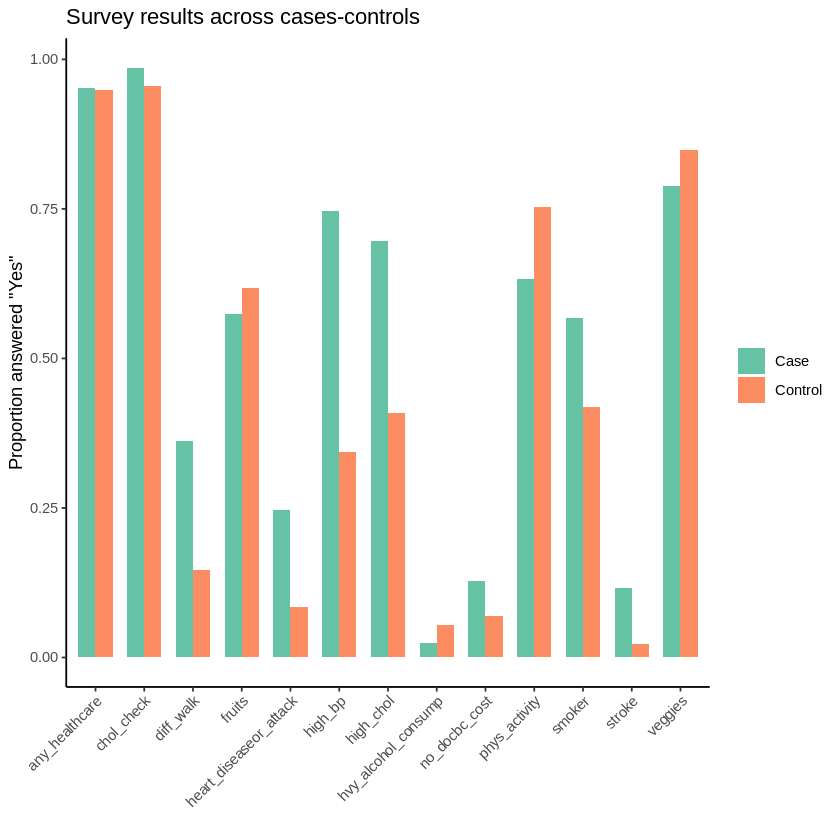

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(col)

  # Now:
  data %>% select(all_of(col))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


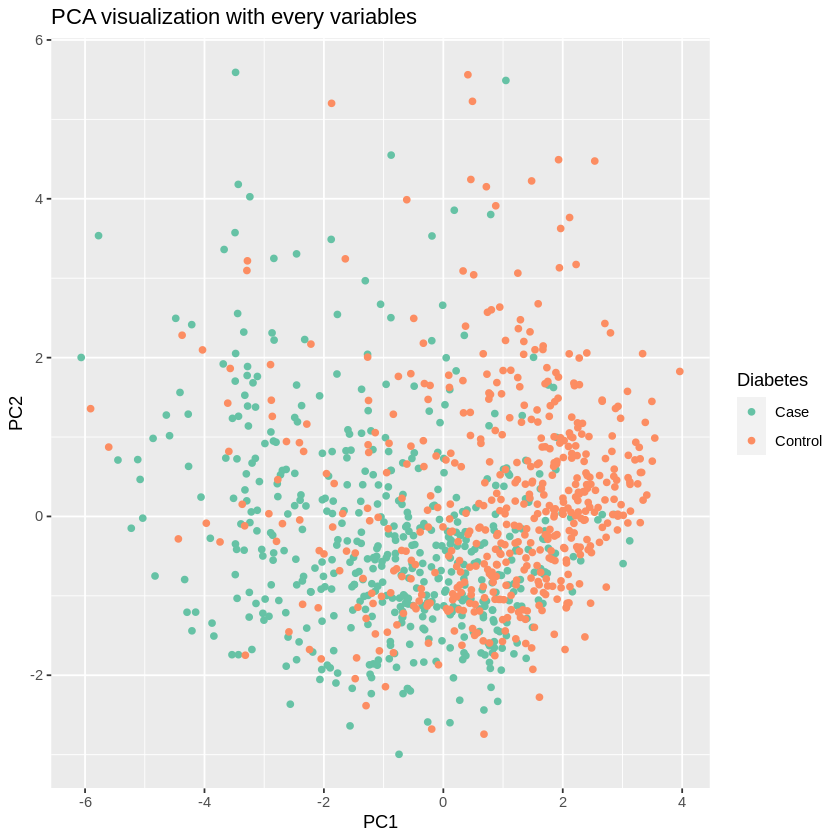

,Variable,PC1,PC2
,<chr>,<dbl>,<dbl>
diff_walk,DiffWalk,0.4084404,-0.2037552
heart_diseaseor_attack,HeartDiseaseorAttack,0.3259212,0.1359641
high_bp,HighBP,0.3719378,0.3410403
high_chol,HighChol,0.3298664,0.2928799
phys_activity,PhysActivity,-0.2732009,0.2127683
bmi,BMI,0.2230676,-0.1774499
gen_hlth,GenHlth,0.4747745,-0.2352894
ment_hlth,MentHlth,0.2336370,-0.5457620
age,Age,0.2746037,0.5549184


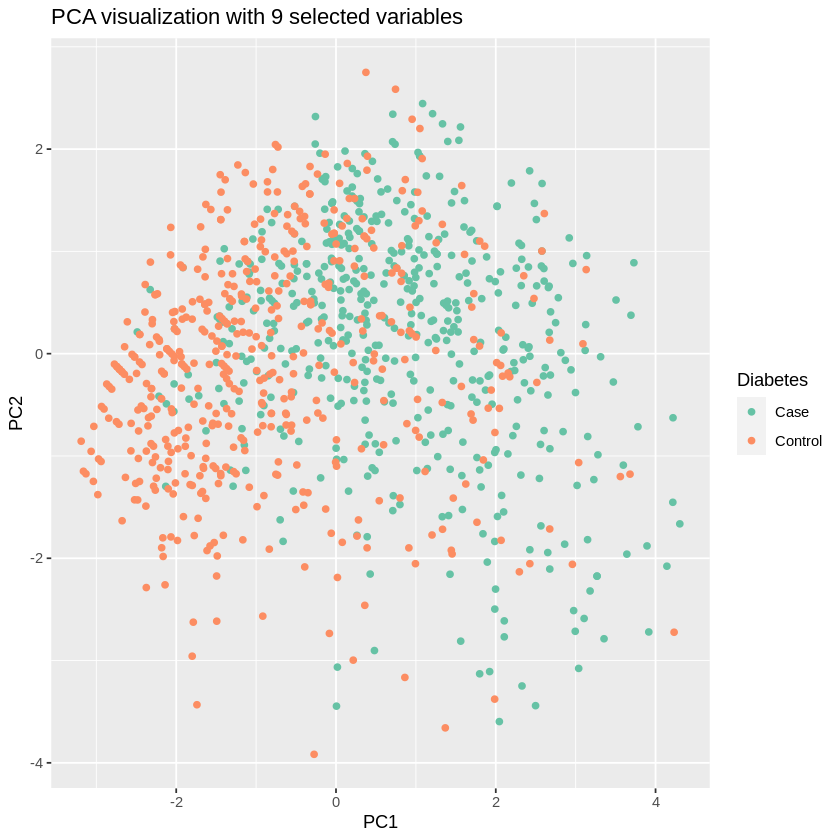

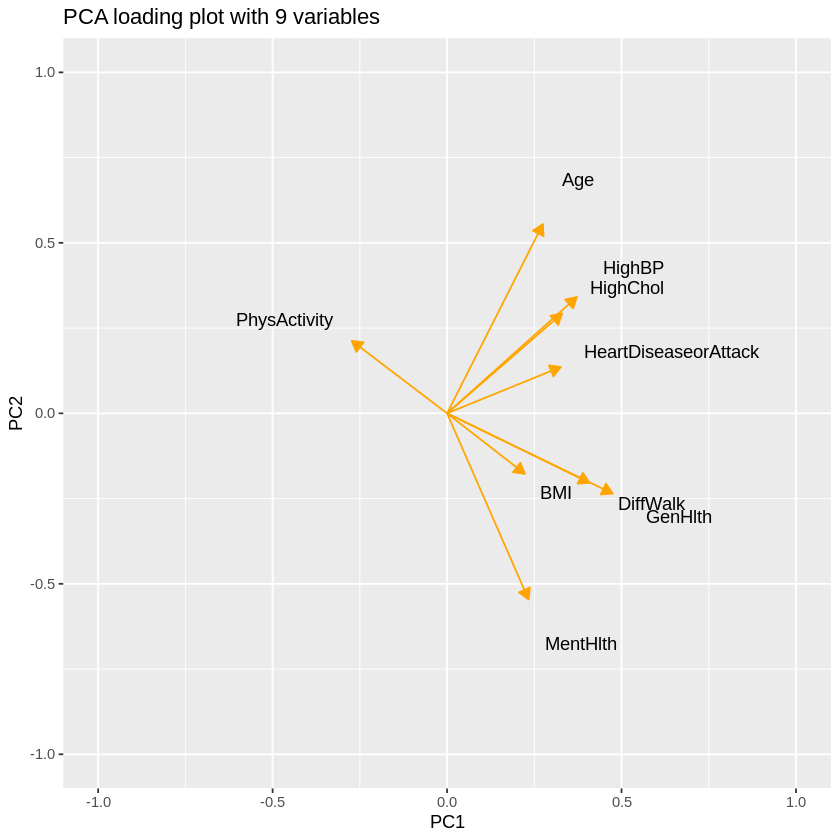

In [1]:
#################################################
## LOADING IN, PROCESSING AND SUBSAMPLING DATA ##
#################################################

# Loading in Libraries
rm(list = ls())
library(tidyverse)
library(tidymodels)
library(ranger)
library(janitor)
library(vip)


# Setting seed for reproducibility
set.seed(123)


# Loading in Data
url <- 'https://github.com/MatildaBae/dsci-100-2023W1-group45/raw/main/data/diabetes_binary_5050split_health_indicators_BRFSS2015.csv'
diab_data <- read_csv(url)


# Formatting column classes appropriately
age_levels <- c('[18,24]', 
                '[25,29]', 
                '[30,34]', 
                '[35,39]', 
                '[40,44]', 
                '[45,49]', 
                '[50,54]', 
                '[55,59]', 
                '[60,64]', 
                '[65,69]', 
                '[70,74]', 
                '[75,79]', 
                '[79,∞)')

diab_data <- diab_data %>% 
        mutate(across(everything(), as_factor)) %>%
        mutate(Diabetes_binary = fct_recode(Diabetes_binary, 'Case' = '1', 'Control' = '0')) %>%
        mutate(Diabetes_binary = factor(Diabetes_binary, levels = c('Case', 'Control'))) %>%
        mutate(Sex = fct_recode(Sex, 'Female' = '0', 'Male' = '1')) %>%
        mutate(Sex = factor(Sex, levels = c('Male', 'Female'))) %>%
        mutate(Age = fct_recode(Age, 
                                '[18,24]' = '1',
                                '[25,29]' = '2',
                                '[30,34]' = '3',
                                '[35,39]' = '4',
                                '[40,44]' = '5',
                                '[45,49]' = '6',
                                '[50,54]' = '7',
                                '[55,59]' = '8',
                                '[60,64]' = '9',
                                '[65,69]' = '10',
                                '[70,74]' = '11',
                                '[75,79]' = '12',
                                '[79,∞)' = '13')) %>%
        mutate(Age = factor(Age, levels = age_levels)) %>%
        mutate(BMI = as.numeric(BMI),
               MentHlth = as.numeric(MentHlth),
               GenHlth = as.numeric(GenHlth)) %>%
        clean_names()


# Splitting data into training-testing subsets (1000 training observations, remainder are test)
set.seed(123)
diab_split <- diab_data %>%
        initial_split(prop = 0.01415,
                      strata = diabetes_binary)
diab_train <- diab_split %>%
        training()
diab_test <- diab_split %>%
        testing()


# Exploring BMI data
summary_bmi <- diab_train %>% 
  select(diabetes_binary, bmi) %>%
  group_by(diabetes_binary) %>%
  summarize(mean_bmi = mean(bmi),
            sd_bmi = sd(bmi))
summary_bmi


# Plotting BMI frequency
mean_bmi_case <- summary_bmi %>% 
        filter(diabetes_binary == 'Case') %>% 
        pull(mean_bmi)

mean_bmi_control <- summary_bmi %>% 
        filter(diabetes_binary == 'Control') %>% 
        pull(mean_bmi)

bmi_plot <- diab_train %>%
  ggplot(aes(x = bmi, fill = diabetes_binary)) +
  geom_histogram(bins = 30, 
                 color = 'white',
                 linewidth = 0.5,
                 alpha = 0.5,
                 position = 'identity') +
  geom_vline(xintercept = mean_bmi_case, color = 'darkgreen', linewidth = 1) +
  geom_vline(xintercept = mean_bmi_control, color = 'red', linewidth = 1) +
  scale_x_continuous(limits = c(0, 60),
                     breaks = seq(0, 60, 10)) +
  labs(x = 'Body Mass Index (BMI)', 
       y = 'Count',
       fill = '') +
  ggtitle('BMI distribution across cases-controls') +
  scale_fill_brewer(palette = 'Set2') +
  theme_classic() +
  theme(text = element_text(size = 12))
bmi_plot


# General and Mental Health scores
diab_train %>% select(diabetes_binary, gen_hlth, ment_hlth) %>%
  group_by(diabetes_binary) %>%
  summarize(across(gen_hlth:ment_hlth, mean, .names = 'mean_{.col}'),
            across(gen_hlth:ment_hlth, sd, .names = 'sd_{.col}'))


# Plotting age data
diab_train %>% 
  select(diabetes_binary, age) %>%
  count(diabetes_binary, age) 

age_plot <- diab_train %>%
  select(diabetes_binary, age) %>%
  ggplot(aes(x = age, fill = diabetes_binary)) +
  geom_bar(stat = 'count', 
           position = 'identity',
           color = 'white',
           alpha = 0.5,
           width = 1) +
  labs(x = 'Age bracket',
       y = 'Count',
       fill = '') +
  ggtitle('Age distribution across cases-controls') +
  scale_fill_brewer(palette = 'Set2') +
  theme_classic() +
  theme(text = element_text(size = 12),
        panel.grid.major = element_blank(),
        axis.text.x = element_text(angle = 45, hjust = 1))
age_plot


# Population plot
diab_train %>% 
  count(diabetes_binary, 
        age, 
        sex) %>%
  mutate(n = ifelse(sex == 'Male', 
                    n * -1, 
                    n)) %>%
  ggplot(aes(x = age, 
             y = n, 
             fill = diabetes_binary)) +
  geom_bar(stat = 'identity', 
           position = 'dodge',
           color = 'white',
           width = 1) +
  labs(x = 'Age bracket', 
       y = 'Count',
       fill = '') +
  ggtitle('Age and gender distribution across case-controls') +
  coord_flip() +
  scale_fill_brewer(palette = 'Set2') +
  theme_classic() +
  scale_y_continuous(labels = abs,
                     expand = c(0,0)) +
  facet_wrap(~sex, 
             strip.position = 'bottom', 
             scale = 'free_x') +
  theme(text = element_text(size = 12), 
        panel.spacing.x = unit(0, 'pt'))


# Sex data
diab_train %>% 
  count(diabetes_binary, sex) %>%
  ggplot(aes(x = diabetes_binary,
             y = n,
             fill = sex)) +
  geom_bar(stat = 'identity', 
           position = 'fill') +
  labs(x = '',
       y = 'Proportion',
       fill = '') +
  ggtitle('Sex distribution across cases-controls') +
  scale_fill_brewer(palette = 'Set2') +
  theme_classic()


# Looking at binary survey data
diab_summary <- diab_train %>% 
  select(-sex) %>%
  group_by(diabetes_binary) %>% 
  summarize(across(where(~ is.factor(.x) && length(unique(.x)) == 2), ~ sum(. == "1") / n(), .names = '{.col}'))

survey_plot <- diab_summary %>%
  pivot_longer(!diabetes_binary) %>%
  ggplot(aes(x = name, y = value, fill = diabetes_binary)) +
  geom_bar(stat = 'identity', position = 'dodge', width = 0.7) +
  labs(x = '', y = 'Proportion answered "Yes"', fill = '') +
  ggtitle("Survey results across cases-controls") +
  scale_fill_brewer(palette = 'Set2') +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
survey_plot


##########################
# EXPLORATORY CLUSTERING #
##########################

# Before selecting variables, visualize classification

# Change factor variables into numeric for visualization
factor_cols_all <- sapply(diab_train, is.factor)

diab_vis_all <- diab_train %>%
  mutate_if(factor_cols_all, as.integer)

selected_numeric_all <- diab_vis_all[, factor_cols_all]
selected_numeric_all <- selected_numeric_all - 1

diab_vis_all[, factor_cols_all] <- selected_numeric_all

# Perform PCA
pca_all <- prcomp(diab_vis_all[, -which(names(diab_vis_all) == 'diabetes_binary')], 
                  scale. = TRUE)

# Extract the first two principal components
pca_data_all <- as.data.frame(pca_all$x[, 1:2])
colnames(pca_data_all) <- c("PC1", "PC2")

# Add target variable for coloring
pca_data_all$diabetes_binary <- diab_train$diabetes_binary

# Plot using ggplot
pca_vis_all <- ggplot(aes(x=PC1, y=PC2, color=diabetes_binary), 
                           data = pca_data_all) +
  geom_point() +
  scale_color_brewer(palette = 'Set2') +
  ggtitle("PCA visualization with every variables") +
  labs(color= "Diabetes")

pca_vis_all

# Select 9 variables by observing plots from each variables
col <- c("diabetes_binary","diff_walk", "heart_diseaseor_attack", "high_bp", "high_chol", "phys_activity", "bmi", "gen_hlth", "ment_hlth", "age") 

diab_sel <- diab_train %>%
  select(col)


# Change factor variables into numeric for visualization
factor_cols <- sapply(diab_sel, is.factor)

diab_vis <- diab_sel %>%
  mutate_if(factor_cols, as.integer)

selected_numeric <- diab_vis[, factor_cols]
selected_numeric <- selected_numeric - 1

diab_vis[, factor_cols] <- selected_numeric

# Visualize data in 2-dimensions plot
# Perform PCA
pca <- prcomp(diab_vis[, -which(names(diab_vis) == 'diabetes_binary')], scale. = TRUE)

# Extract the first two principal components
pca_data <- as.data.frame(pca$x[, 1:2])
colnames(pca_data) <- c("PC1", "PC2")

# Add target variable for coloring
pca_data$diabetes_binary <- diab_train$diabetes_binary

# Plot using ggplot
pca_vis <- ggplot(aes(x=PC1, y=PC2, color=diabetes_binary), data = pca_data) +
  geom_point() +
  scale_color_brewer(palette = 'Set2') +
  ggtitle("PCA visualization with 9 selected variables") +
  labs(color= "Diabetes")

pca_vis

# Create a data frame for plotting the loading vectors
loading_plot <- data.frame(
  Variable = colnames(pca$rotation),
  PC1 = pca$rotation[, 1],  # PC1 loadings
  PC2 = pca$rotation[, 2]   # PC2 loadings
)

new_row_names <- c("DiffWalk", "HeartDiseaseorAttack", "HighBP", " HighChol", 
                   "PhysActivity", "BMI", "GenHlth", "MentHlth", "Age")
loading_plot$Variable <- new_row_names
loading_plot

# Plot the PCA loading plot with arrows
ggplot(loading_plot, aes(x = 0, y = 0, xend = PC1, yend = PC2)) +
  geom_segment(arrow = arrow(type = "closed", length = unit(0.1, "inches")), color = "orange") +
  geom_text(aes(label = Variable, x = PC1 * 1.2, y = PC2 * 1.2), 
            hjust = ifelse(loading_plot$PC1 > 0, 0, 1),  # Adjust horizontal position
            vjust = ifelse(loading_plot$PC2 > 0, 0, 1)) +
  xlim(-1, 1) + ylim(-1, 1) +
  labs(x = "PC1", y = "PC2", title = "PCA loading plot with 9 variables")


In [ ]:
################################
# RANDOM FOREST CLASSIFICATION #
################################

# Setting up folds for cross-validation
set.seed(456)
diab_cv <- diab_train %>% 
  vfold_cv(v = 10, strata = diabetes_binary)


# Setting up recipe
diab_recipe <- recipe(diabetes_binary ~ ., diab_train) %>%
  step_normalize(all_numeric_predictors()) %>%
  step_dummy(all_factor_predictors())


# Setting up model specification
cv_spec <- rand_forest(mtry = tune(), 
                       min_n = tune(),
                       trees = 1001) %>%
  set_engine('ranger', seed = 456) %>%
  set_mode('classification')


# Setting up workflow object
cv_workflow <- workflow() %>%
  add_recipe(diab_recipe) %>%
  add_model(cv_spec)


# Pairs of mtry, min_n values to try
tune_grid <- tibble(mtry = rep(seq(to=13, by=3), each = 5),
                    min_n = rep(seq(from = 5, to = 25, by = 5), 5))

# 10-fold cross-validation
set.seed(456)

cv_results <- cv_workflow %>% 
  tune_grid(resamples = diab_cv, grid = tune_grid) %>%
  collect_metrics()


# Inspecting cross-validation results
cv_params <- cv_results %>% 
  filter(.metric == 'accuracy') %>% 
  select(mtry, min_n, mean) %>%
  arrange(desc(mean))
cv_params

param_plot <- cv_params %>%
  ggplot(aes(x = mtry, 
             y = mean, color = factor(min_n))) +
           geom_point() +
           geom_line() +
  labs(y = 'Mean accuracy', color = 'min_n') +
  scale_color_brewer(palette = 'Set2') +
  theme_classic() +
  theme(text = element_text(size = 12))
param_plot

mtry_param <- cv_params %>% 
  slice_head(n = 1) %>% 
  select(mtry) %>% 
  pull()
min_n_param <- cv_params %>% 
  slice_head(n = 1) %>% 
  select(min_n) %>% 
  pull()

print(mtry_param)
print(min_n_param)

In [ ]:
# Setting up final model specification
set.seed(456)
rf_spec <- rand_forest(mtry = mtry_param, 
                       min_n = min_n_param, 
                       trees = 1001) %>% 
  set_engine('ranger',
             importance = 'impurity') %>%
  set_mode('classification')

# Setting up final workflow, fitting model
rf_wf <- workflow() %>%
  add_model(rf_spec) %>%
  add_recipe(diab_recipe)

rf_fit <- rf_wf %>%
  fit(diab_train)


# Generating predictions on test set, examining results
rf_predict <- rf_fit %>%
  predict(diab_test) %>% bind_cols(diab_test)

rf_predict %>%
  metrics(truth = diabetes_binary, .pred_class)

rf_prob <- rf_fit %>% 
  predict(diab_test, type = 'prob') %>%
  bind_cols(diab_test)


# ROC curve plot
rf_prob %>% roc_auc(truth = diabetes_binary, .pred_Case)

rf_prob %>%
  roc_curve(truth = diabetes_binary, .pred_Case) %>%
  autoplot() +
  labs(x = 'True positive rate', 
       y = 'False positive rate') +
  ggtitle('ROC curve (AUC = 0.818)') +
  theme(text = element_text(size = 12)) +
  theme_classic()


# Confusion matrix
rf_predict %>%
  conf_mat(truth = diabetes_binary, estimate = .pred_class)


# F1 score, sensitivity, specificity  
rf_predict %>%
  f_meas(truth = diabetes_binary, estimate = .pred_class) %>% 
  bind_rows(rf_predict %>%
              sens(truth = diabetes_binary, estimate = .pred_class), 
            rf_predict %>% 
              spec(truth = diabetes_binary, estimate = .pred_class))




# Variable importance scores
rf_fit %>% 
  extract_fit_parsnip() %>% 
  vip() +
  labs(y = 'Variable Importance') +
  theme_classic() +
  theme(text = element_text(size = 12))




#########################
## LOGISTIC REGRESSION ##
#########################

lr_spec <- logistic_reg() %>%
  set_engine('glm') %>%
  set_mode('classification')

lr_wf <- workflow() %>%
  add_recipe(diab_recipe) %>%
  add_model(lr_spec)

lr_fit <- lr_wf %>%
  fit(diab_train)

lr_predict <- lr_fit %>%
  predict(diab_test)

lr_predict %>% bind_cols(diab_test) %>% metrics(truth = diabetes_binary, estimate = .pred_class)